In [35]:
import cv2
import mediapipe as mp
import numpy as np
import csv
import os

# Initialize MediaPipe Hand Detector
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(max_num_hands=1, min_detection_confidence=0.7)
mp_drawing = mp.solutions.drawing_utils

# Labels for sign language (A-Z)
labels = {chr(i): i - ord('A') for i in range(ord('A'), ord('Z') + 1)}
data_dir = "sign_data"

# Ensure directory exists
os.makedirs(data_dir, exist_ok=True)

# Define ROI Box (Region of Interest) - (x_min, y_min, x_max, y_max)
ROI_BOX = (400, 0, 639, 220)  # Adjust as needed

def extract_keypoints(results, frame_shape):
    """Extract keypoints if the hand is inside the ROI."""
    if results.multi_hand_landmarks:
        hand_landmarks = results.multi_hand_landmarks[0]
        
        # Compute the bounding box of the hand
        x_min = min([lm.x for lm in hand_landmarks.landmark]) * frame_shape[1]
        y_min = min([lm.y for lm in hand_landmarks.landmark]) * frame_shape[0]
        x_max = max([lm.x for lm in hand_landmarks.landmark]) * frame_shape[1]
        y_max = max([lm.y for lm in hand_landmarks.landmark]) * frame_shape[0]

        # Check if the hand is inside the ROI
        if x_min >= ROI_BOX[0] and y_min >= ROI_BOX[1] and x_max <= ROI_BOX[2] and y_max <= ROI_BOX[3]:
            return np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks.landmark]).flatten()
    
    return np.zeros(63)  # Return zero vector if no hand detected or outside ROI

cap = cv2.VideoCapture(0)
current_label = None
count = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    frame = cv2.flip(frame, 1)
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(rgb_frame)
    
    # Always Draw the ROI Box
    cv2.rectangle(frame, (ROI_BOX[0], ROI_BOX[1]), (ROI_BOX[2], ROI_BOX[3]), (0, 255, 255), 2)
    cv2.putText(frame, "ROI Box", (ROI_BOX[0], ROI_BOX[1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)

    if current_label:
        keypoints = extract_keypoints(results, frame.shape)
        
        if keypoints.sum() != 0:  # Only save if hand is inside ROI
            file_path = os.path.join(data_dir, f"{current_label}.csv")
            with open(file_path, "a", newline="") as f:
                writer = csv.writer(f)
                writer.writerow(list(keypoints) + [current_label])
                count += 1

            if results.multi_hand_landmarks:
                for hand_landmarks in results.multi_hand_landmarks:
                    mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

            cv2.putText(frame, f"Recording {current_label} ({count}/200)", (50, 50), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

            if count >= 200:
                current_label = None
                count = 0  # Reset count after recording 200 entries
    
    cv2.putText(frame, "Press A-Z to start recording", (50, 450), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    cv2.imshow("Data Collection", frame)
    
    key = cv2.waitKey(1) & 0xFF
    if key == ord('4'):  # Press '4' to quit
        break
    if chr(key).upper() in labels:
        current_label = chr(key).upper()
        count = 0  # Reset count for new label
        file_path = os.path.join(data_dir, f"{current_label}.csv")
        with open(file_path, "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerow([f"p{i}" for i in range(63)] + ["label"])  # Column names

cap.release()
cv2.destroyAllWindows()


# DATA CREATION for A-Z, SPACE & SUBMIT

In [1]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Define labels (A-Z) + "Submit"
labels = [chr(i) for i in range(ord('A'), ord('Z') + 1)] + ["SUBMIT"]+["SPACE"]

# Create and save the label encoder
encoder = LabelEncoder()
encoder.fit(labels)
np.save("label_classes.npy", encoder.classes_)

print("Label classes saved:", encoder.classes_)


Label classes saved: ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'SPACE' 'SUBMIT' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']


In [29]:
import cv2
import mediapipe as mp
import numpy as np
import csv
import os

# Initialize MediaPipe Hand Detector
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(max_num_hands=1, min_detection_confidence=0.7)
mp_drawing = mp.solutions.drawing_utils

# Labels for sign language (A-Z) + Submit sign
labels = {chr(i): i - ord('A') for i in range(ord('A'), ord('Z') + 1)}
labels["SPACE"] = len(labels)  # Assign a unique index for "Submit" sign
labels["SUBMIT"] = len(labels)  # Assign a unique index for "Submit Shift" sign

data_dir = "sign_data"

# Ensure directory exists
os.makedirs(data_dir, exist_ok=True)

# Define ROI Box (Region of Interest) - (x_min, y_min, x_max, y_max)
ROI_BOX = (400, 0, 639, 220)  # Adjust as needed

def extract_keypoints(results, frame_shape):
    """Extract keypoints if the hand is inside the ROI."""
    if results.multi_hand_landmarks:
        hand_landmarks = results.multi_hand_landmarks[0]
        
        # Compute the bounding box of the hand
        x_min = min([lm.x for lm in hand_landmarks.landmark]) * frame_shape[1]
        y_min = min([lm.y for lm in hand_landmarks.landmark]) * frame_shape[0]
        x_max = max([lm.x for lm in hand_landmarks.landmark]) * frame_shape[1]
        y_max = max([lm.y for lm in hand_landmarks.landmark]) * frame_shape[0]

        # Check if the hand is inside the ROI
        if x_min >= ROI_BOX[0] and y_min >= ROI_BOX[1] and x_max <= ROI_BOX[2] and y_max <= ROI_BOX[3]:
            return np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks.landmark]).flatten()
    
    return np.zeros(63)  # Return zero vector if no hand detected or outside ROI

cap = cv2.VideoCapture(0)
current_label = None
count = 0
recording = False  # Flag to indicate if recording is in progress

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    frame = cv2.flip(frame, 1)
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(rgb_frame)
    
    # Always Draw the ROI Box
    cv2.rectangle(frame, (ROI_BOX[0], ROI_BOX[1]), (ROI_BOX[2], ROI_BOX[3]), (0, 255, 255), 2)
    cv2.putText(frame, "ROI Box", (ROI_BOX[0], ROI_BOX[1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)

    if recording:
        keypoints = extract_keypoints(results, frame.shape)
        
        if keypoints.sum() != 0:  # Only save if hand is inside ROI
            file_path = os.path.join(data_dir, f"{current_label}.csv")
            with open(file_path, "a", newline="") as f:
                writer = csv.writer(f)
                writer.writerow(list(keypoints) + [current_label])
                count += 1

            if results.multi_hand_landmarks:
                for hand_landmarks in results.multi_hand_landmarks:
                    mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

            cv2.putText(frame, f"Recording {current_label} ({count}/300)", (50, 50), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

            if count >= 200:
                recording = False  # Stop recording after 300 frames
                current_label = None  # Reset label
                count = 0  # Reset count
    
    cv2.putText(frame, "Press A-Z, Space for Submit, Shift for Submit Shift", (50, 450), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    cv2.imshow("Data Collection", frame)
    
    key = cv2.waitKey(1) & 0xFF
    if key == ord('4'):  # Press '4' to quit
        break
    elif not recording:  # Only allow new recording if not already in progress
        if key == ord(' '):  # Space key for Submit
            current_label = "SPACE"
            recording = True  # Start recording
        elif key == 225:  # Shift key for Submit Shift
            current_label = "SUBMIT"
            recording = True  # Start recording
        elif chr(key).upper() in labels:
            current_label = chr(key).upper()
            recording = True  # Start recording

        if recording:
            count = 0  # Reset count for new label
            file_path = os.path.join(data_dir, f"{current_label}.csv")
            with open(file_path, "w", newline="") as f:
                writer = csv.writer(f)
                writer.writerow([f"p{i}" for i in range(63)] + ["label"])  # Column names

cap.release()
cv2.destroyAllWindows()


In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os
import numpy as np

data_dir = "sign_data"
data = []
labels = []

# Define the correct class order (A-Z, then SUBMIT)
class_labels = [chr(i) for i in range(ord('A'), ord('Z') + 1)] + ["SUBMIT"]+ ["SPACE"]
label_map = {label: i for i, label in enumerate(class_labels)}  # A-Z = 0-25, SUBMIT = 26

# Load data from CSV files
for file in os.listdir(data_dir):
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join(data_dir, file))
        data.extend(df.iloc[:, :-1].values)
        labels.extend(df.iloc[:, -1].values)

# Convert to numpy arrays
X = np.array(data, dtype=np.float32)
y = np.array([label_map[label] for label in labels])  # Assign correct numeric labels

# Normalize X (optional)
X = (X - np.min(X)) / (np.max(X) - np.min(X))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Samples: {len(X_train)}, Test Samples: {len(X_test)}")
print(f"Class Mapping: {label_map}")  # Debugging: Print correct label mapping


Training Samples: 4560, Test Samples: 1140
Class Mapping: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'SUBMIT': 26, 'SPACE': 27}


In [31]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

# Ensure correct number of classes (A-Z + SUBMIT = 27)
num_classes = len(class_labels)

# Convert labels to one-hot encoding
y_train_ohe = to_categorical(y_train, num_classes)
y_test_ohe = to_categorical(y_test, num_classes)

# Define the 1D CNN Model
model = models.Sequential([
    layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(63, 1)),
    layers.Conv1D(128, kernel_size=3, activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # Output adjusted for 27 classes
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Reshape X for 1D CNN
X_train_cnn = X_train.reshape(-1, 63, 1)
X_test_cnn = X_test.reshape(-1, 63, 1)

# Train the model
history = model.fit(X_train_cnn, y_train_ohe, epochs=20, batch_size=16, validation_data=(X_test_cnn, y_test_ohe))

# Save the model
model.save("sign_language_model.h5")


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 61, 64)            256       
                                                                 
 conv1d_11 (Conv1D)          (None, 59, 128)           24704     
                                                                 
 flatten_5 (Flatten)         (None, 7552)              0         
                                                                 
 dense_10 (Dense)            (None, 128)               966784    
                                                                 
 dense_11 (Dense)            (None, 28)                3612      
                                                                 
Total params: 995,356
Trainable params: 995,356
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
285/285 [============================

37/37 [==============================] - 0s 2ms/step


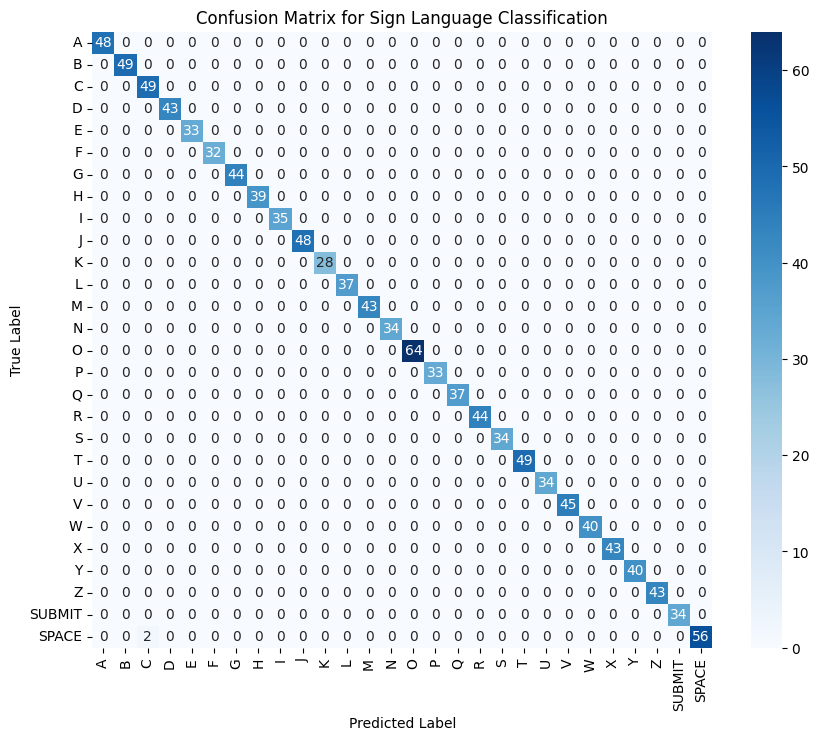

Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        48
           B       1.00      1.00      1.00        49
           C       0.96      1.00      0.98        49
           D       1.00      1.00      1.00        43
           E       1.00      1.00      1.00        33
           F       1.00      1.00      1.00        32
           G       1.00      1.00      1.00        44
           H       1.00      1.00      1.00        39
           I       1.00      1.00      1.00        35
           J       1.00      1.00      1.00        48
           K       1.00      1.00      1.00        28
           L       1.00      1.00      1.00        37
           M       1.00      1.00      1.00        43
           N       1.00      1.00      1.00        34
           O       1.00      1.00      1.00        64
           P       1.00      1.00      1.00        33
           Q       1.00      1.00      1.00        37
    

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Make predictions
y_pred = model.predict(X_test_cnn)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test_ohe, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Define class labels (A-Z)
# class_labels = [chr(i) for i in range(ord('A'), ord('Z') + 1)]

# num_classes = y_pred.shape[1]  
class_labels = [chr(i) for i in range(ord('A'), ord('Z') + 1)]
if num_classes == 28:  
    class_labels.append("SUBMIT")
    class_labels.append("SPACE")

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Sign Language Classification")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=class_labels))


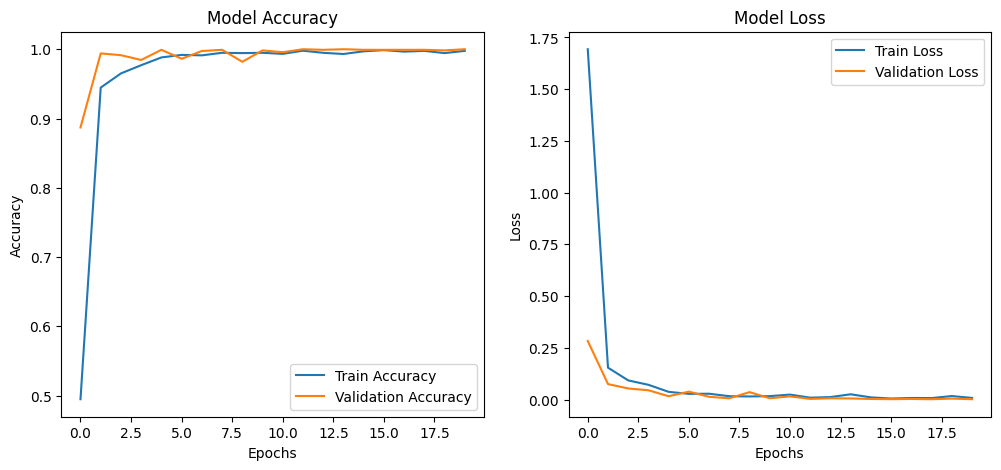

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.legend()

plt.show()

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import mediapipe as mp

# Load trained model
model = tf.keras.models.load_model("sign_language_model.h5")

# Load label encoder
encoder = LabelEncoder()
encoder.classes_ = np.load("label_classes.npy", allow_pickle=True)

# Initialize MediaPipe
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(max_num_hands=1, min_detection_confidence=0.7)
mp_drawing = mp.solutions.drawing_utils

def extract_keypoints(results):
    if results.multi_hand_landmarks:
        hand_landmarks = results.multi_hand_landmarks[0]
        return np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks.landmark]).flatten()
    return np.zeros(63)

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    frame = cv2.flip(frame, 1)
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(rgb_frame)

    keypoints = extract_keypoints(results)

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

    # Predict sign
    keypoints = keypoints.reshape(1, 63, 1)
    prediction = model.predict(keypoints)
    predicted_label = encoder.inverse_transform([np.argmax(prediction)])[0]

    cv2.putText(frame, f"Prediction: {predicted_label}", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow("Sign Language Detection", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [11]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Define labels (A-Z)
labels = [chr(i) for i in range(ord('A'), ord('Z') + 1)]
# labels = [ 'A','B','C','D','E']

# Create and save the label encoder
encoder = LabelEncoder()
encoder.fit(labels)
np.save("label_classes.npy", encoder.classes_)

print("Label classes saved:", encoder.classes_)



Label classes saved: ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']


In [76]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Define labels (A-Z) + "Submit"
labels = [chr(i) for i in range(ord('A'), ord('Z') + 1)] + ["SUBMIT"]+["SPACE"]

# Create and save the label encoder
encoder = LabelEncoder()
encoder.fit(labels)
np.save("label_classes.npy", encoder.classes_)

print("Label classes saved:", encoder.classes_)


Label classes saved: ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'SPACE' 'SUBMIT' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']


7/7 [==============================] - 3s 76ms/step


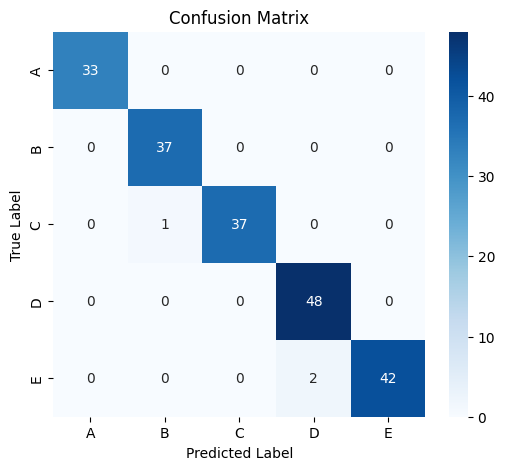

Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        33
           B       0.97      1.00      0.99        37
           C       1.00      0.97      0.99        38
           D       0.96      1.00      0.98        48
           E       1.00      0.95      0.98        44

    accuracy                           0.98       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.98      0.98       200



In [22]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Load the trained model
model = tf.keras.models.load_model("sign_language_model.h5")

# Make predictions
y_pred_probs = model.predict(X_test_cnn)  # Get probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels
y_true = np.argmax(y_test_ohe, axis=1)  # Convert one-hot labels back to integers

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define class labels (modify as per your dataset)
labels = ["A", "B", "C", "D", "E"]  # Update with actual sign labels if needed

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import mediapipe as mp

# Load trained model
model = tf.keras.models.load_model("sign_language_model.h5")

# Initialize MediaPipe Hand Detector
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(max_num_hands=1, min_detection_confidence=0.7)
mp_drawing = mp.solutions.drawing_utils

# Labels (A-Z)
class_labels = [chr(i) for i in range(ord('A'), ord('Z') + 1)]

def extract_keypoints_from_image(image):
    """Extract hand keypoints from an image using MediaPipe."""
    rgb_frame = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(rgb_frame)

    if results.multi_hand_landmarks:
        hand_landmarks = results.multi_hand_landmarks[0]
        keypoints = np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks.landmark]).flatten()
        return keypoints
    return np.zeros(63)  # Return zero vector if no hand detected

# Open webcam or load an image
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.flip(frame, 1)  # Mirror the image
    keypoints = extract_keypoints_from_image(frame)

    if keypoints.sum() != 0:  # If hand detected
        input_data = keypoints.reshape(1, 63, 1)  # Reshape for model
        prediction = model.predict(input_data)
        predicted_label = class_labels[np.argmax(prediction)]  # Get letter

        # Display the predicted letter
        cv2.putText(frame, f"Prediction: {predicted_label}", (50, 50), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    cv2.imshow("Sign Language Prediction", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):  # Press 'q' to quit
        break

cap.release()
cv2.destroyAllWindows()


In [32]:
import cv2
import numpy as np
import tensorflow as tf
import mediapipe as mp

# Load trained model
model = tf.keras.models.load_model("sign_language_model.h5")

# Initialize MediaPipe Hand Detector
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(max_num_hands=1, min_detection_confidence=0.7)
mp_drawing = mp.solutions.drawing_utils

# Labels (A-Z) + Submit
class_labels = [chr(i) for i in range(ord('A'), ord('Z') + 1)]
class_labels.append("SUBMIT")  # Add "SUBMIT" class
class_labels.append("SPACE")

def extract_keypoints_from_image(image):
    """Extract hand keypoints from an image using MediaPipe."""
    rgb_frame = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(rgb_frame)

    if results.multi_hand_landmarks:
        hand_landmarks = results.multi_hand_landmarks[0]
        keypoints = np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks.landmark]).flatten()
        return keypoints, results.multi_hand_landmarks  # Return keypoints and landmarks
    return np.zeros(63), None  # Return zero vector and no landmarks if no hand detected

# Open webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.flip(frame, 1)  # Mirror the image
    keypoints, landmarks = extract_keypoints_from_image(frame)

    if keypoints.sum() != 0:  # If hand detected
        input_data = keypoints.reshape(1, 63, 1)  # Reshape for model
        prediction = model.predict(input_data)
        predicted_label = class_labels[np.argmax(prediction)]  # Get letter or "SUBMIT"

        # Display the predicted letter
        cv2.putText(frame, f"Prediction: {predicted_label}", (50, 50), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Draw hand key points
        for hand_landmarks in landmarks:
            mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

    cv2.imshow("Sign Language Prediction", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):  # Press 'q' to quit
        break

cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 14ms/step
